In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import pandas as pd
import re
import json

In [2]:
judge_model_name = "Qwen/Qwen2.5-7B-Instruct"

tokenizer_judge = AutoTokenizer.from_pretrained(judge_model_name)

model_judge = AutoModelForCausalLM.from_pretrained(
    judge_model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

`torch_dtype` is deprecated! Use `dtype` instead!
2025-12-25 23:55:31.903551: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-25 23:55:33.366725: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-25 23:55:36.847529: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
import pandas as pd

file_path = "/faststorage/project/DEIC-SDU-L2-22/llmproject/yelp/history/results_predictions_yelpwithhis.json"
df = pd.read_json(file_path)
df.head()

,prompt,true_label,predicted_label
0,You are a rating prediction expert. Based on t...,5,5
1,You are a rating prediction expert. Based on t...,5,5
2,You are a rating prediction expert. Based on t...,5,5
3,You are a rating prediction expert. Based on t...,5,5
4,You are a rating prediction expert. Based on t...,5,5


In [4]:
print(df["prompt"].iloc[0])

You are a rating prediction expert. Based on the review text and user/business information, predict the rating (stars) the user will give.
Return only the rating as a single integer from 1 to 5, with no additional text.

Review Info: review_id=kcytuaMFAxiOl4k1cBeF2A, user_id=--Vu3Gux9nPnLcG9yO_HxA, business_id=gwGLBmNTfIlaTnwFtddbkQ
Review Text: "History: lobster mac cheese was phenomenal. the clam chowder crab cakes are the best in town. the lobster meat was so sweet and fresh. cant wait to go back and try more delicious food. [stars:5]; i love this place! the beer cheese bread bowl is delicious. the gooey, melted cheese is my favorite and the bread is so fresh. they also have a good selection of great tasting beer. my favorite is the bitchin berry when they carry it! [stars:5]; love their delicious selection of mini and jumbo muffins! they always have a seasonal flavor which is cool such as the pumpkin spice during fall time. they also have coffee and blended drinks if youre in the m

In [10]:
# import re
# import json
# import pandas as pd
# import torch

# # -----------------------------------------------------
# # 1. Prompt du juge (avec gestion history / no history)
# # -----------------------------------------------------
# def create_judge_prompt(summary, user_history, predicted_rating):

#     history_block = (
#         f"User History:\n{user_history}\n\n"
#         if user_history.strip() != ""
#         else "User History:\nNo history available. Judge coherence based ONLY on the review summary.\n\n"
#     )

#     prompt = (
#         "You are a Yelp rating coherence evaluator.\n"
#         "Your task is to judge whether the predicted rating matches the user's review summary "
#         "and, if available, the user's past history.\n\n"
#         "You MUST respond STRICTLY in valid JSON format like this:\n"
#         "{\n"
#         "  \"coherence_score\": float between 0 and 1,\n"
#         "  \"verdict\": \"coherent\" or \"incoherent\",\n"
#         "  \"explanation\": \"short explanation\"\n"
#         "}\n\n"
#         f"{history_block}"
#         f"Review Summary:\n{summary}\n\n"
#         f"Predicted Rating: {predicted_rating}\n\n"
#         "Return ONLY valid JSON. No extra text."
#     )
#     return prompt


# # -----------------------------------------------------
# # 2. Appel du modèle + normalisation
# # -----------------------------------------------------
# def ask_qwen_judge(prompt):

#     inputs = tokenizer_judge(prompt, return_tensors="pt").to(model_judge.device)

#     with torch.no_grad():
#         output = model_judge.generate(
#             **inputs,
#             max_new_tokens=200,
#             temperature=0.2,
#             do_sample=True
#         )

#     full_text = tokenizer_judge.decode(output[0], skip_special_tokens=True)

#     # Nettoyage
#     generated = full_text.replace(prompt, "").strip()
#     generated = generated.replace("```json", "").replace("```", "").strip()

#     try:
#         result = json.loads(generated)
#     except:
#         result = {}

#     # -------------------------
#     # NORMALISATION DU SCORE
#     # -------------------------
#     try:
#         score = float(result.get("coherence_score", 0.0))
#         if score > 1.0:
#             score /= 5.0
#     except:
#         score = 0.0

#     if score >= 0.8:
#         verdict = "coherent"
#     elif score >= 0.5:
#         verdict = "partially coherent"
#     else:
#         verdict = "incoherent"

#     explanation = result.get(
#         "explanation",
#         "Coherence judged based on available information."
#     )

#     return {
#         "coherence_score": round(score, 2),
#         "verdict": verdict,
#         "explanation": explanation
#     }


# # -----------------------------------------------------
# # 3. Charger le dataset Yelp
# # -----------------------------------------------------
# file_path = "/faststorage/project/DEIC-SDU-L2-22/llmproject/yelp/history/results_predictions_yelpwithhis.json"
# df = pd.read_json(file_path)

# print(f"Dataset chargée : {len(df)} exemples")


# # -----------------------------------------------------
# # 4. Évaluation (TEST SUR 10 EXEMPLES)
# # -----------------------------------------------------
# records = []
# df_test = df.head(10)

# for idx, prompt_text in enumerate(df_test["prompt"]):

#     # ---- Extraction History
#     history_match = re.search(
#         r'History:\s*(.*?)\s*New review:',
#         prompt_text,
#         re.DOTALL | re.IGNORECASE
#     )
#     user_history = history_match.group(1).strip() if history_match else ""

#     # ---- Extraction New Review / Summary
#     review_match = re.search(
#         r'New review:\s*(.*?)\s*### Response:',
#         prompt_text,
#         re.DOTALL | re.IGNORECASE
#     )
#     summary = review_match.group(1).strip() if review_match else ""

#     predicted_rating = df_test["predicted_label"].iloc[idx]

#     judge_prompt = create_judge_prompt(
#         summary=summary,
#         user_history=user_history,
#         predicted_rating=predicted_rating
#     )

#     judge_output = ask_qwen_judge(judge_prompt)

#     records.append({
#         "user_history": user_history,
#         "review_summary": summary,
#         "predicted_rating": predicted_rating,
#         "coherence_score": judge_output["coherence_score"],
#         "verdict": judge_output["verdict"],
#         "explanation": judge_output["explanation"],
#         "used_history": user_history.strip() != ""
#     })


# # -----------------------------------------------------
# # 5. Résultats
# # -----------------------------------------------------
# results = pd.DataFrame(records)

# print("===== SUMMARY TABLE (TEST 10) =====")
# print(results[[
#     "predicted_rating",
#     "coherence_score",
#     "verdict",
#     "used_history",
#     "explanation"
# ]])

# results.to_csv("llm_judge_json_output.csv", index=False)


Dataset chargée : 92745 exemples
===== SUMMARY TABLE (TEST 10) =====
   predicted_rating  coherence_score     verdict  used_history  \
0                 5              1.0    coherent          True   
1                 5              0.0  incoherent          True   
2                 5              0.0  incoherent          True   
3                 5              0.0  incoherent          True   
4                 5              0.0  incoherent          True   
5                 5              0.0  incoherent          True   
6                 5              1.0    coherent          True   
7                 4              1.0    coherent          True   
8                 5              0.8    coherent          True   
9                 3              0.0  incoherent          True   

                                         explanation  
0  The review summary mentions the delicious sele...  
1   Coherence judged based on available information.  
2   Coherence judged based on available

In [5]:
import re
import json
import pandas as pd
import torch
from tqdm import tqdm

# -----------------------------------------------------
# 1. Prompt du juge (history / no history)
# -----------------------------------------------------
def create_judge_prompt(summary, user_history, predicted_rating):

    history_block = (
        f"User History:\n{user_history}\n\n"
        if user_history.strip() != ""
        else "User History:\nNo history available. Judge coherence based ONLY on the review summary.\n\n"
    )

    prompt = (
        "You are a Yelp rating coherence evaluator.\n"
        "Your task is to judge whether the predicted rating matches the user's review summary "
        "and, if available, the user's past history.\n\n"
        "You MUST respond STRICTLY in valid JSON format like this:\n"
        "{\n"
        "  \"coherence_score\": float between 0 and 1,\n"
        "  \"verdict\": \"coherent\" or \"incoherent\",\n"
        "  \"explanation\": \"short explanation\"\n"
        "}\n\n"
        f"{history_block}"
        f"Review Summary:\n{summary}\n\n"
        f"Predicted Rating: {predicted_rating}\n\n"
        "Return ONLY valid JSON. No extra text."
    )
    return prompt


# -----------------------------------------------------
# 2. Appel du modèle + normalisation
# -----------------------------------------------------
def ask_qwen_judge(prompt):

    inputs = tokenizer_judge(prompt, return_tensors="pt").to(model_judge.device)

    with torch.no_grad():
        output = model_judge.generate(
            **inputs,
            max_new_tokens=200,
            temperature=0.2,
            do_sample=True
        )

    full_text = tokenizer_judge.decode(output[0], skip_special_tokens=True)
    generated = full_text.replace(prompt, "").strip()
    generated = generated.replace("```json", "").replace("```", "").strip()

    try:
        result = json.loads(generated)
    except:
        result = {}

    # Normalisation du score
    try:
        score = float(result.get("coherence_score", 0.0))
        if score > 1.0:
            score /= 5.0
    except:
        score = 0.0

    if score >= 0.8:
        verdict = "coherent"
    elif score >= 0.5:
        verdict = "partially coherent"
    else:
        verdict = "incoherent"

    explanation = result.get(
        "explanation",
        "Coherence judged based on available information."
    )

    return {
        "coherence_score": round(score, 2),
        "verdict": verdict,
        "explanation": explanation
    }


# -----------------------------------------------------
# 3. Charger le dataset Yelp
# -----------------------------------------------------
file_path = "/faststorage/project/DEIC-SDU-L2-22/llmproject/yelp/history/results_predictions_yelpwithhis.json"
df = pd.read_json(file_path)

print(f"Dataset chargée : {len(df)} exemples")


Dataset chargée : 92745 exemples


In [ ]:
# -----------------------------------------------------
# 4. Évaluation SUR TOUTE LA DATASET (AVEC BATCH)
# -----------------------------------------------------
BATCH_SIZE = 10   # ajuste selon ta VRAM
records = []

for start_idx in tqdm(range(0, len(df), BATCH_SIZE), desc="LLM Judge"):

    batch = df.iloc[start_idx:start_idx + BATCH_SIZE]

    for _, row in batch.iterrows():

        prompt_text = row["prompt"]

        # Extraction History
        history_match = re.search(
            r'History:\s*(.*?)\s*New review:',
            prompt_text,
            re.DOTALL | re.IGNORECASE
        )
        user_history = history_match.group(1).strip() if history_match else ""

        # Extraction Review / Summary
        review_match = re.search(
            r'New review:\s*(.*?)\s*### Response:',
            prompt_text,
            re.DOTALL | re.IGNORECASE
        )
        summary = review_match.group(1).strip() if review_match else ""

        predicted_rating = row["predicted_label"]

        judge_prompt = create_judge_prompt(
            summary=summary,
            user_history=user_history,
            predicted_rating=predicted_rating
        )

        judge_output = ask_qwen_judge(judge_prompt)

        records.append({
            "predicted_rating": predicted_rating,
            "coherence_score": judge_output["coherence_score"],
            "verdict": judge_output["verdict"],
            "used_history": user_history.strip() != "",
            "explanation": judge_output["explanation"]
        })


# -----------------------------------------------------
# 5. Sauvegarde finale en JSON
# -----------------------------------------------------
output_path = "llm_judge_results_full_dataset.json"

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(records, f, indent=2, ensure_ascii=False)

print(f" Résultats sauvegardés dans : {output_path}")


LLM Judge:   0%|▎                                                                                                      | 26/9275 [08:33<49:43:51, 19.36s/it]

In [1]:
!nvidia-smi

/usr/local/bin/bash-login-check: line 1: nvidia-smi: command not found


In [2]:
import pandas as pd

file_path = "llm_judge_results_full_dataset.json"
df = pd.read_json(file_path)

print("Head of the dataset:")
print(df.head())

verdict_percentages = (
    df["verdict"]
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
)

print("\nVerdict percentage distribution:")
print(verdict_percentages)


Head of the dataset:
   predicted_rating  coherence_score     verdict  used_history  \
0                 5              1.0    coherent          True   
1                 5              0.0  incoherent          True   
2                 5              0.0  incoherent          True   
3                 5              0.0  incoherent          True   
4                 5              0.0  incoherent          True   

                                         explanation  
0  The review summary mentions the delicious sele...  
1   Coherence judged based on available information.  
2   Coherence judged based on available information.  
3   Coherence judged based on available information.  
4   Coherence judged based on available information.  

Verdict percentage distribution:
verdict
incoherent            46.38
coherent              44.34
partially coherent     9.28
Name: proportion, dtype: float64


              Verdict  Percentage
0          incoherent       46.38
1            coherent       44.34
2  partially coherent        9.28


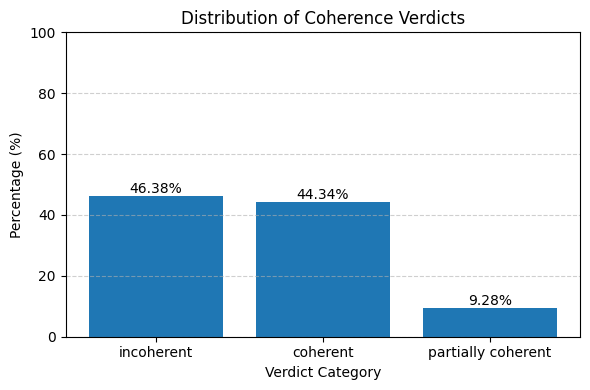

In [4]:
import matplotlib.pyplot as plt
verdict_percentages = (
    df["verdict"]
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .reset_index()
)

verdict_percentages.columns = ["Verdict", "Percentage"]

# Display table
print(verdict_percentages)

plt.figure(figsize=(6, 4))
plt.bar(
    verdict_percentages["Verdict"],
    verdict_percentages["Percentage"]
)

plt.ylabel("Percentage (%)")
plt.xlabel("Verdict Category")
plt.title("Distribution of Coherence Verdicts")
plt.ylim(0, 100)

for i, value in enumerate(verdict_percentages["Percentage"]):
    plt.text(i, value + 1, f"{value}%", ha="center", fontsize=10)

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("verdict_distribution_bar.png", dpi=300)
plt.show()


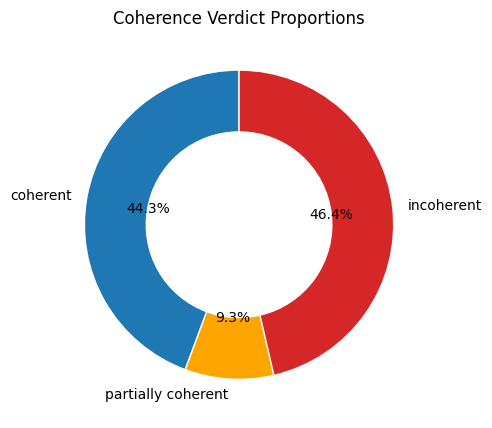

In [5]:
import matplotlib.pyplot as plt

# Ensure consistent ordering
order = ["coherent", "partially coherent", "incoherent"]

# Reorder dataframe safely
verdict_df = (
    verdict_percentages
    .set_index("Verdict")
    .reindex(order)
    .dropna()
)

# Define colors
color_map = {
    "coherent": "tab:blue",              # green
    "partially coherent": "orange",    # grey
    "incoherent": "#d62728"             # red
}

colors = [color_map[v] for v in verdict_df.index]

# Plot donut chart
plt.figure(figsize=(5, 5))
plt.pie(
    verdict_df["Percentage"],
    labels=verdict_df.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.4, edgecolor="white")
)

plt.title("Coherence Verdict Proportions")
plt.tight_layout()
plt.savefig("verdict_distribution_donut_colored.png", dpi=300)
plt.show()
